In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_30884\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [3]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - polna luna

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med polno luno, razlikuje od ritmičnosti ostalih nesreč.

In [4]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'Full Moon')

accidents_full_moon = accidents_moon[moon_mask]
# display(accidents_full_moon)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_full_moon['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsFullMoon",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

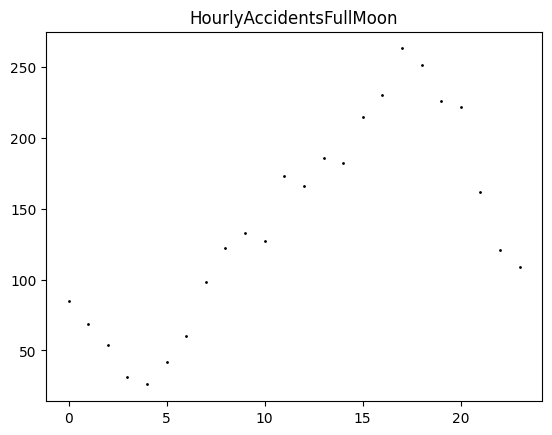

In [5]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsFullMoon"])

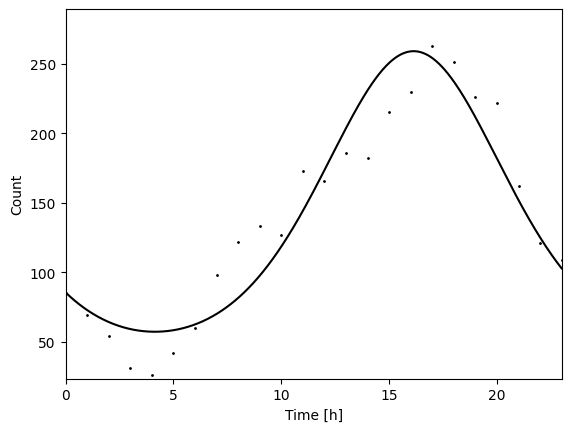

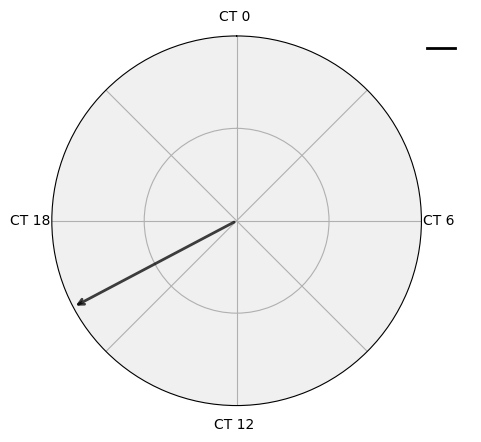

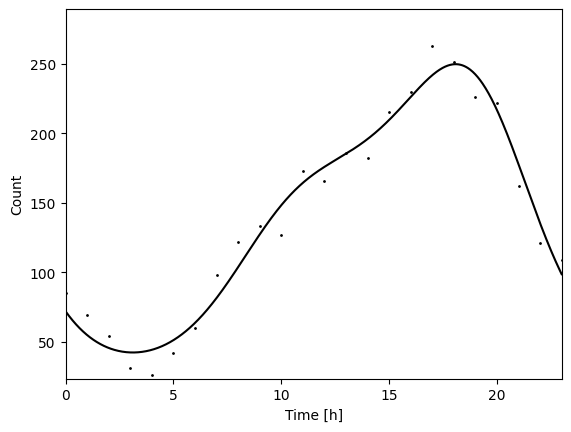

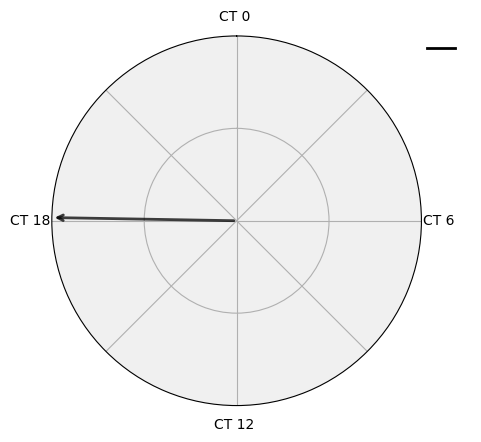

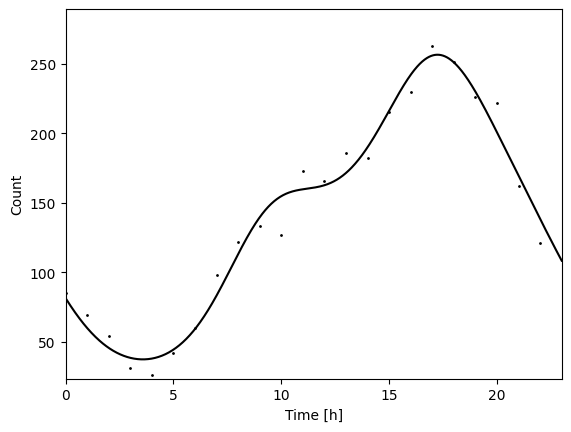

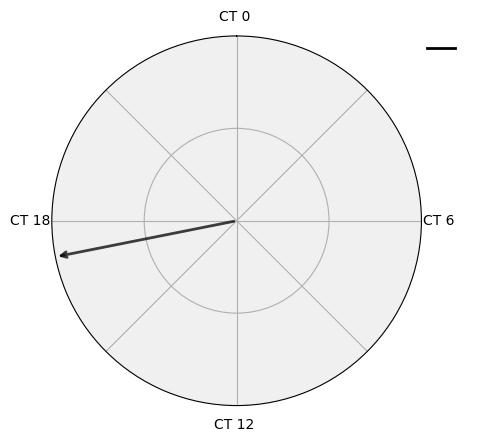

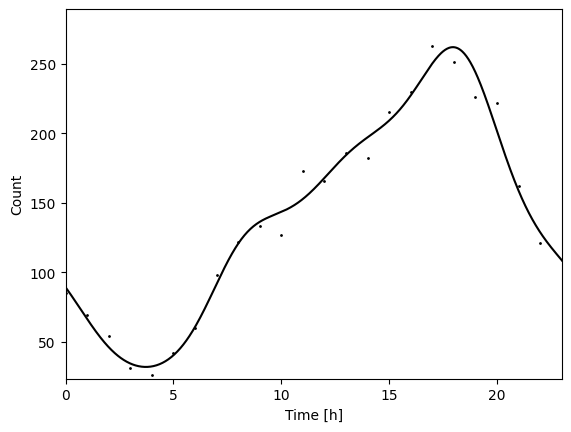

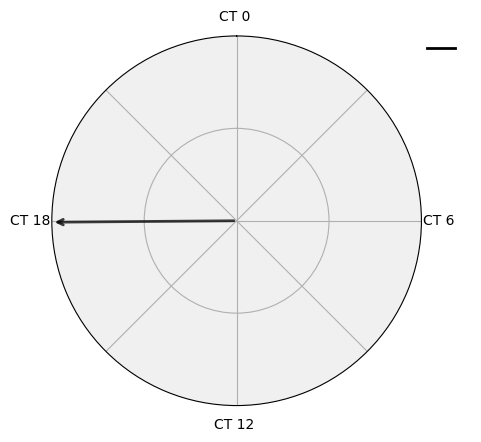

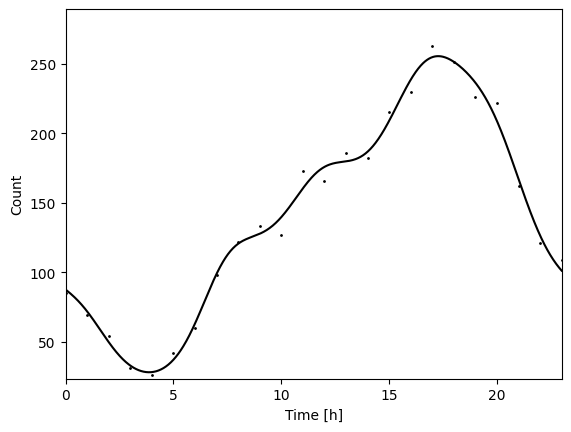

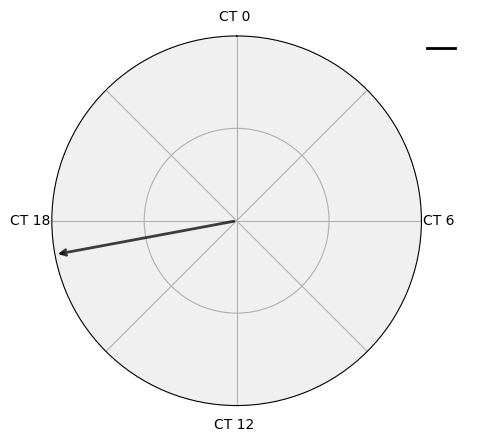

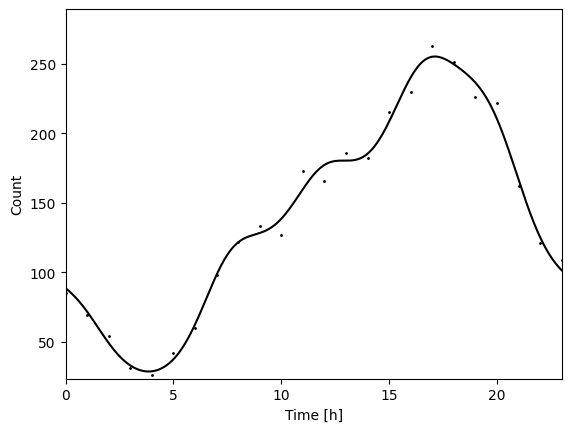

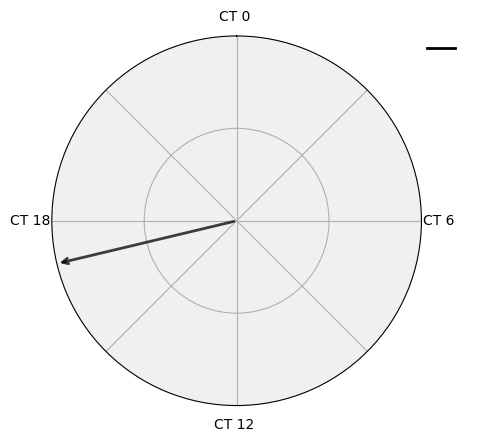

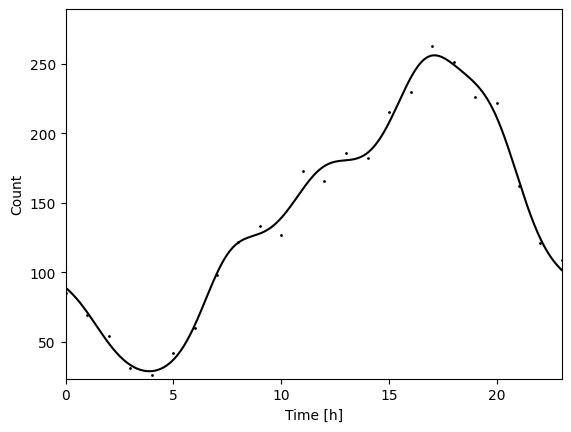

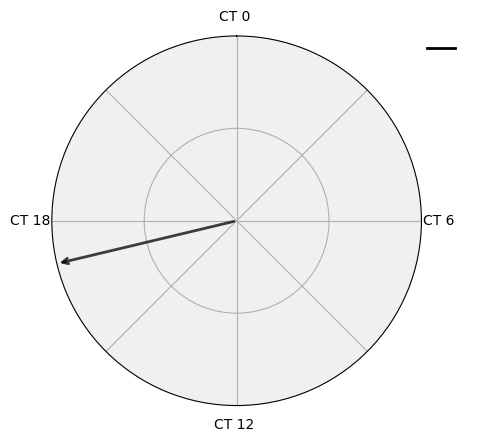

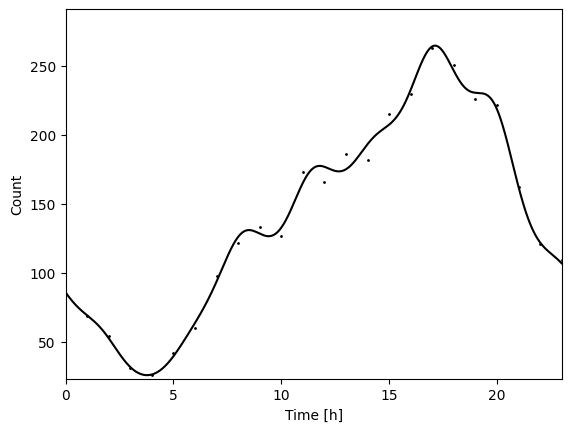

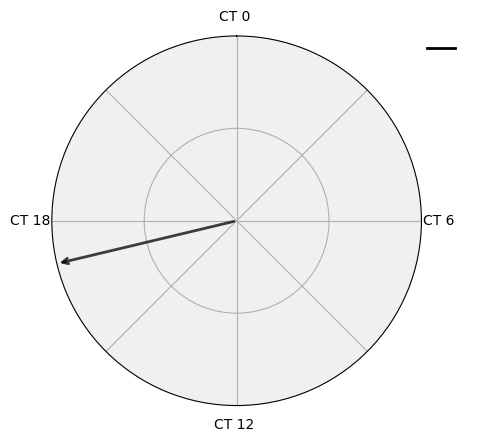

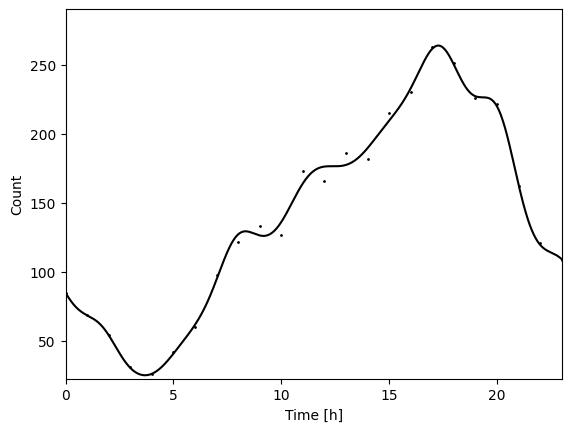

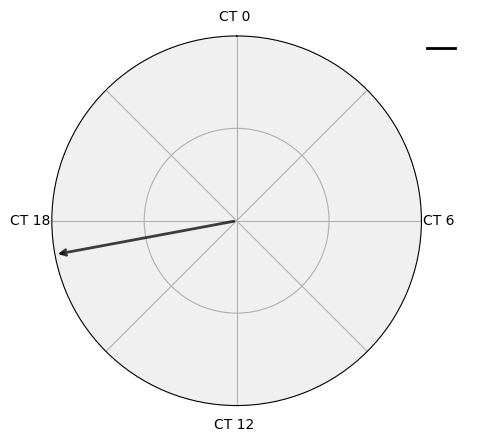

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


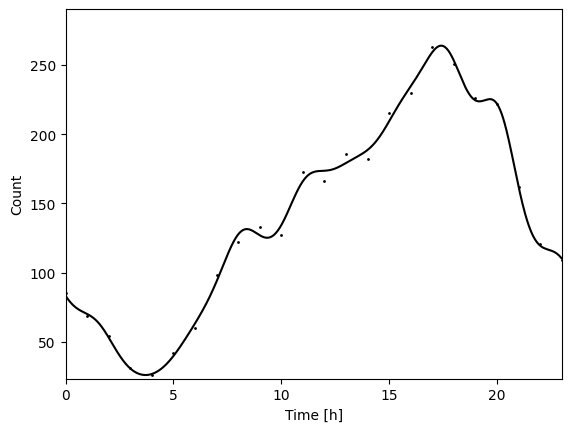

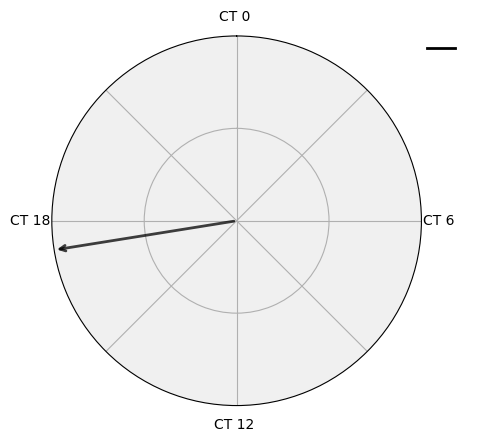

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsFullMoon', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFullMoon,24.0,1.0,2.906292e-12,2.906292e-12,13852.442492,-111.182567,0.192848,100.924374,2.056658,158.119580,[16.144144144144143],[259.04395337179204],[4.132132132132132],[57.19520611518109]
1,HourlyAccidentsFullMoon,24.0,2.0,1.474407e-16,1.638229e-16,3806.780534,-97.575874,0.291628,103.708946,1.553500,145.982170,[18.066066066066067],[249.68898248217323],[3.123123123123123],[42.27322350627526]
2,HourlyAccidentsFullMoon,24.0,3.0,1.794239e-17,2.242798e-17,2967.466209,-92.199077,0.330662,109.588735,1.767342,146.905403,[17.24924924924925],[256.49413808390375],[3.6036036036036037],[37.31843270540066]
3,HourlyAccidentsFullMoon,24.0,4.0,4.981510e-19,8.302516e-19,2244.972085,-85.467370,0.379532,115.030411,1.578658,146.910172,[17.96996996996997],[261.9405826876146],[3.6996996996997],[31.881753196322098]
4,HourlyAccidentsFullMoon,24.0,5.0,6.298901e-21,2.229564e-20,1160.278707,-77.981096,0.433881,113.705260,1.754763,141.763644,[17.2972972972973],[255.46439931258303],[3.8918918918918917],[28.061863286946963]
5,HourlyAccidentsFullMoon,24.0,6.0,6.289389e-20,1.257878e-19,1136.550055,-77.765781,0.435444,113.300516,1.805079,141.905139,"[12.82882882882883, 17.105105105105103]","[180.31069372154278, 255.20408344143567]",[3.843843843843844],[28.604623055909926]
6,HourlyAccidentsFullMoon,24.0,7.0,6.060775e-19,8.658250e-19,1095.223458,-77.705149,0.435884,113.639334,1.805079,142.433453,[17.105105105105103],[256.07278705277116],[3.8918918918918917],[28.79411908816703]
7,HourlyAccidentsFullMoon,24.0,8.0,5.758930e-21,2.229564e-20,662.137673,-70.056409,0.491411,119.500082,1.805079,145.338054,"[11.771771771771771, 17.105105105105103]","[177.6222445981494, 264.81908921650677]","[3.795795795795796, 9.417417417417417]","[25.842714892128562, 126.61627187552466]"
8,HourlyAccidentsFullMoon,24.0,9.0,6.688692e-21,2.229564e-20,537.830863,-67.795635,0.507824,119.421261,1.754763,144.575102,"[12.3003003003003, 17.2972972972973]","[176.57450605566476, 263.9875997577965]","[3.6996996996997, 9.177177177177176]","[25.158268381496182, 126.0983765480514]"
9,HourlyAccidentsFullMoon,24.0,10.0,1.295062e-20,3.237655e-20,436.481238,-66.188610,0.519490,118.963871,1.729606,145.040642,"[17.393393393393392, 19.65165165165165]","[263.9911486604415, 225.36228120641715]","[3.6996996996997, 9.32132132132132]","[26.07677079593494, 125.2361180644993]"


### Katero je najboljše število komponent

In [8]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFullMoon,24.0,5.0,6.298901e-21,2.229564e-20,1160.278707,-77.981096,0.433881,113.70526,1.754763,141.763644,[17.2972972972973],[255.46439931258303],[3.8918918918918917],[28.061863286946963]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


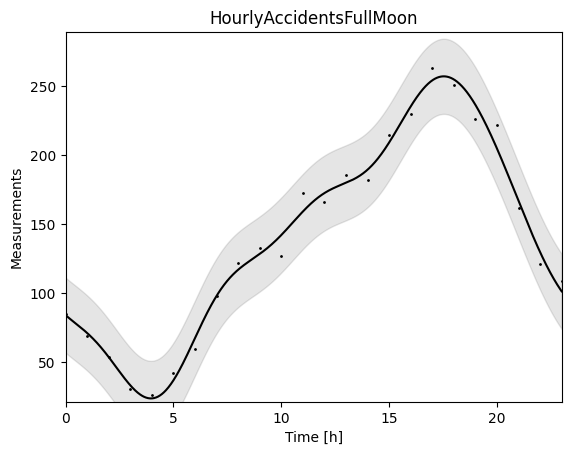

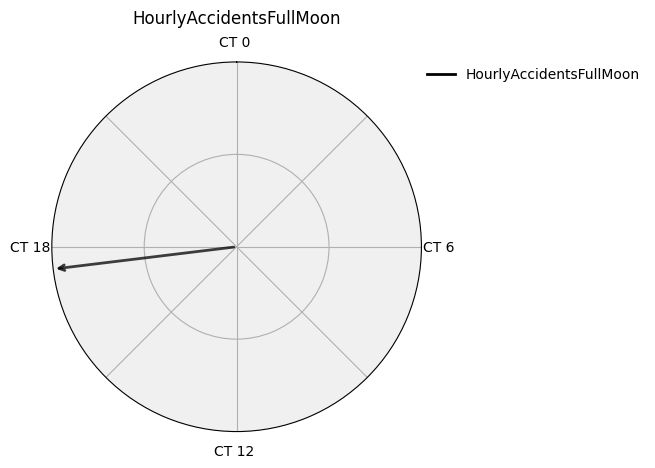

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [18]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsFullMoon",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [19]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

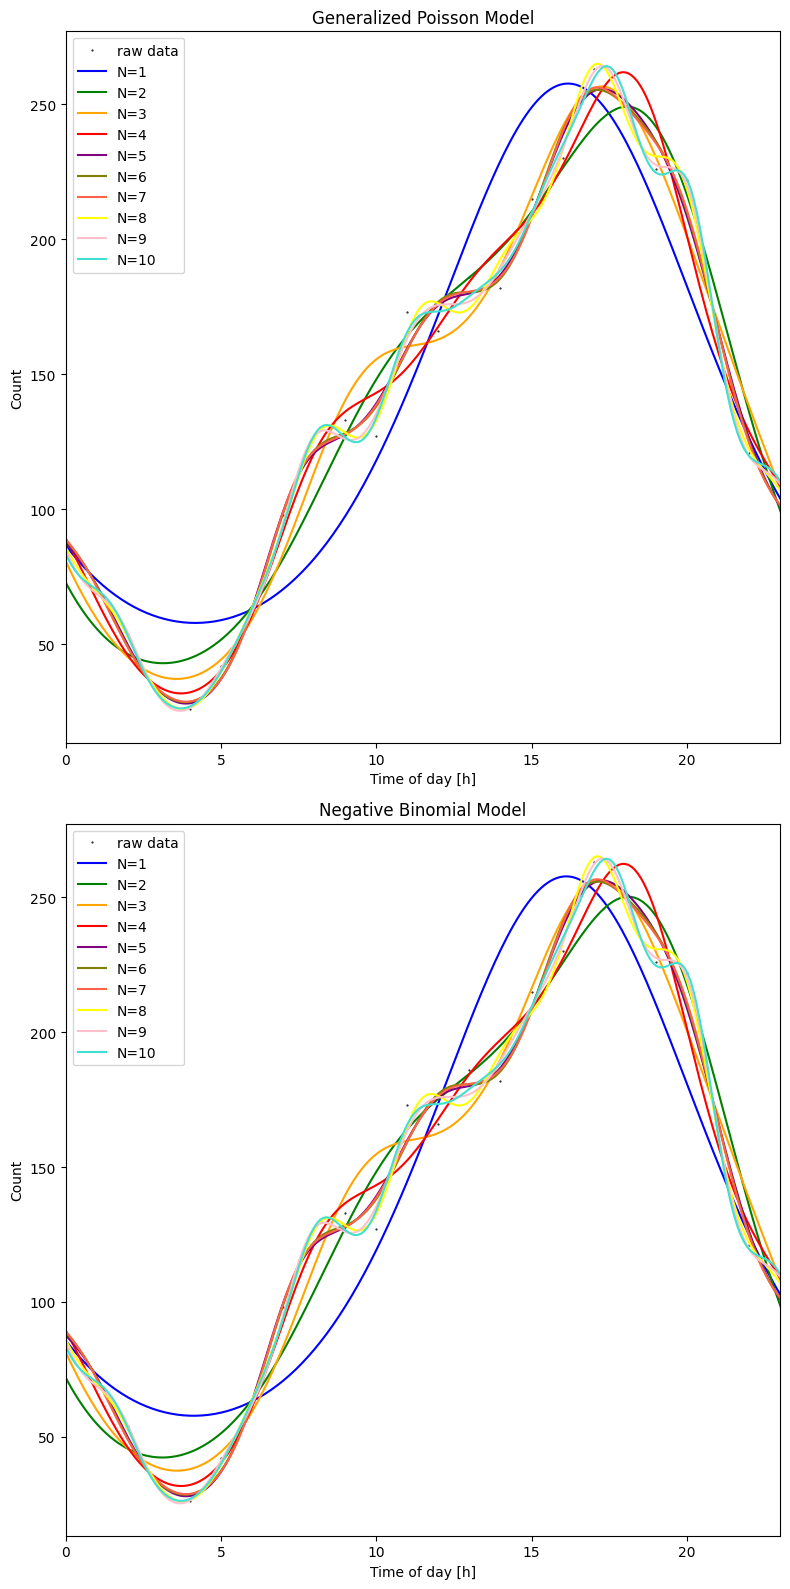

In [20]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [21]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,99.87,157.80,[16.22],[257.67],2.981896e-12,13485.279403,230.416496,235.128712,-111.208248,"[-3.9584889776742926, -3.8569694092979603, -3....",139.789179,"[86.6945234206802, 73.8893443782782, 65.171328...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.6945234206802, 85.21217820128712, 83.77590..."
1,gen_poisson,2,103.06,146.08,[18.12],[249.14],2.254706e-16,3818.493333,208.022539,215.090862,-98.011269,"[-4.00762262351634, -4.295914026532799, -3.513...",140.086409,"[72.97151451056352, 55.794416577869, 46.405840...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[72.97151451056352, 70.84321289269155, 68.8110..."
2,gen_poisson,3,109.70,146.89,[17.22],[256.59],2.540260e-17,2964.293487,201.124858,210.549289,-92.562429,"[-3.174663446806065, -3.8080507330330917, -3.7...",139.783763,"[80.85826829720872, 59.46473397197277, 45.2952...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[80.85826829720872, 78.42045778833237, 76.0434..."
3,gen_poisson,4,115.02,146.85,[17.92],[261.88],6.992304e-19,2246.185333,191.653472,203.434010,-85.826736,"[-3.1658801939914127, -2.9879771722667385, -3....",139.708333,"[89.28458668360047, 66.32936625630802, 45.9942...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[89.28458668360047, 87.09616237352317, 84.8673..."
4,gen_poisson,5,113.78,141.85,[17.32],[255.63],1.693242e-19,1159.096107,187.023519,201.160165,-81.511759,"[-3.08058370452693, -3.002594750627935, -3.010...",139.708333,"[87.55397014480903, 71.8576614946236, 49.80572...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[87.55397014480903, 86.29924695054866, 85.0003..."
5,gen_poisson,6,113.38,141.98,[17.12],[255.36],1.791748e-18,1135.162037,190.848501,207.341254,-81.424250,"[-3.1246034992229426, -2.99227838236375, -3.09...",139.708333,"[88.5467349765432, 71.64817784302501, 49.06074...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[88.5467349765432, 87.23905217412002, 85.86411..."
6,gen_poisson,7,113.75,142.52,[17.12],[256.27],1.676116e-17,1092.206166,194.797825,213.646686,-81.398912,"[-3.14858403830425, -2.975105490880935, -3.116...",139.708333,"[88.9908499217297, 71.26038141720201, 48.88980...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[88.9908499217297, 87.61368775672803, 86.15729..."
7,gen_poisson,8,119.49,145.55,[17.12],[265.04],1.890484e-17,658.829197,194.289363,215.494332,-79.144681,"[-3.038856142368914, -2.9282576177275814, -2.8...",139.708333,"[85.9936769275903, 69.38541369113878, 52.76902...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[85.9936769275903, 83.86338293027657, 81.83259..."
8,gen_poisson,9,119.40,144.78,[17.32],[264.18],9.680526e-17,535.869318,197.418915,220.979992,-78.709458,"[-3.0303276390661296, -2.9264487993570185, -2....",139.708333,"[85.01007591977526, 68.73624331040415, 54.3173...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[85.01007591977526, 82.47806907860833, 80.1321..."
9,gen_poisson,10,118.94,145.21,"[17.42, 19.72]","[264.15, 225.54]",5.138302e-16,435.216429,200.875789,226.792973,-78.437894,"[-3.0467199369223437, -2.9440540466662384, -2....",139.708333,"[83.41814942481862, 70.32179603961758, 53.2232...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[83.41814942481862, 81.16117274992328, 79.1638..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [22]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 5


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [23]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 5
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

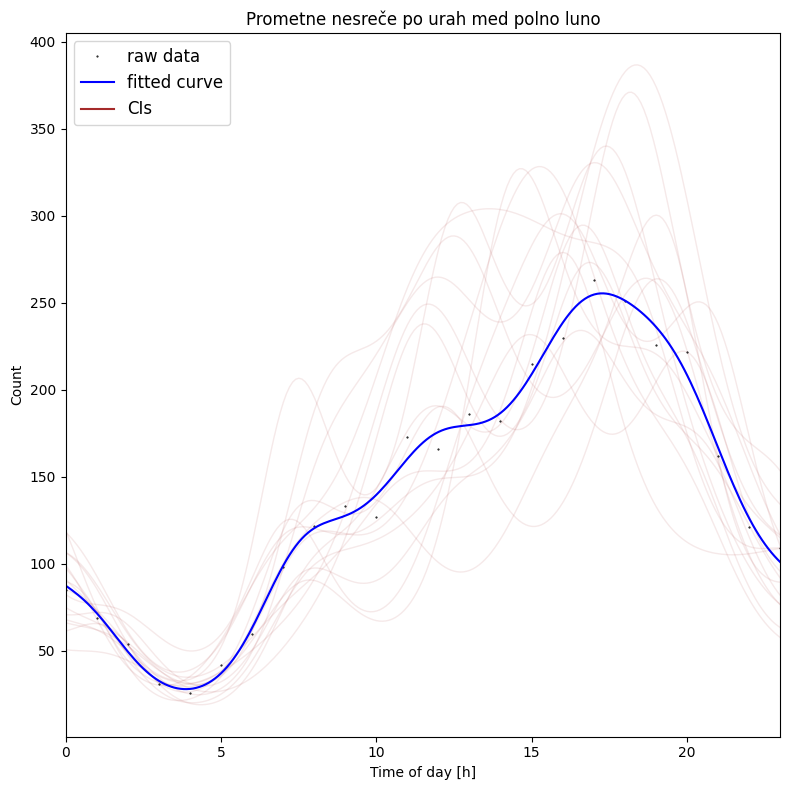

Intervali zaupanja:


,0,1
0,4.631531,4.924814
1,-0.877013,-0.591586
2,-0.712466,-0.221130
3,-0.451618,-0.043192
4,-0.161552,0.183392
5,-0.188700,0.186710
6,0.038074,0.253773
7,-0.022703,0.238009
8,-0.031939,0.164190
9,-0.007226,0.111376


In [24]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med polno luno', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [25]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,5
amplitude,113.78
mesor,141.85
peaks,[17.32]
heights,[255.63]
amplitude_CIs,"[105.62, 126.89]"
mesor_CIs,"[133.12, 154.09]"
peaks_CIs,"[16.38, 18.12]"
heights_CIs,"[239.26, 280.46]"
